This notebook is for computing the trigger efficiency for data

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/control_data2018.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    B={'files': datasets_['B'], 'treename': 'ffNtuples/ffNtuple'} ,
    C={'files': datasets_['C'], 'treename': 'ffNtuples/ffNtuple'} , 
    D={'files': datasets_['D'], 'treename': 'ffNtuples/ffNtuple'} ,
)

In [3]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        
        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "jet pt [GeV]", 50, 0 , 200)
        deltaR_axis = hist.Bin("deltaR", "delta_R", 30, 0 , 5)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'tot_tag_with_probe': hist.Hist("Counts", dataset_axis, pt_axis),
            'tot_tag': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        # IMPORTATANT!!! here you need to add the reference trigger (HLT_Mu17)
            
            
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['muon_p4'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
         
        )            
          
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
         
        )
        
        triggerObjs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_DoubleL2Mu23NoVtx_2Cha'],
            px=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fX'],
            py=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fY'],
            pz=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fZ'],
            energy=df['TOHLT_DoubleL2Mu23NoVtx_2Cha.fCoordinates.fT'],
        )
        
        ####### EFFICIENCY STUDY  #######
        
        ptcut1 = 0   # [GeV]  for tag              # pt = 0 and etacut = 99999999 means NO CUTS
        ptcut2 = 0    # [GeV]  for probe
        etacut = 2.5
        
        # NOTE: add ptcut2 > 1 for probe
        
        
        twoljs = leptonjets.counts >=1
        
        diljs = leptonjets[twoljs]
        triggerObjs = triggerObjs[twoljs]
        
        #leptonjets.offsets
        ptmask1 = diljs.pt>ptcut1
        ptmask2 = diljs.pt>ptcut2
        
        #ptmask1.offsets
        #diljs.offsets
    
        
        diljs.add_attributes(ptmask1 = ptmask1) 
        diljs.add_attributes(ptmask2 = ptmask2) 
        diljs.add_attributes(etamask = diljs.eta<etacut)
        diljs.add_attributes(trgmask = diljs.match(triggerObjs, deltaRCut=0.4))         
        
        diljs = diljs.distincts()    
          
        # now i0 is the tag and i1 is the probe
        tag0Andprobe1_pt = diljs[diljs.i0.trgmask & 
                                 diljs.i0.ptmask1 &
                                 diljs.i1.ptmask2 &
                                 diljs.i0.etamask &
                                 diljs.i1.trgmask].pt.flatten()  
        
        tag0_pt = diljs[diljs.i0.trgmask &
                        diljs.i0.ptmask1 &
                        diljs.i1.ptmask2 &
                        diljs.i0.etamask                       
                       ].pt.flatten()
    
        # now i1 is the tag and i0 is the probe     
        tag1Andprobe0_pt = diljs[diljs.i0.trgmask & 
                                 diljs.i1.ptmask1 &
                                 diljs.i0.ptmask2 &
                                 diljs.i1.etamask &
                                 diljs.i1.trgmask].pt.flatten()  
        
        tag1_pt = diljs[diljs.i1.trgmask & 
                        diljs.i1.ptmask1 &
                        diljs.i0.ptmask2 &
                        diljs.i1.etamask   
                       ].pt.flatten()
        
        # appending the two pairs of pt arrays
        tot_tag_pt = np.append(tag0_pt, tag1_pt)
        tot_tagAndprobe_pt = np.append(tag0Andprobe1_pt, tag1Andprobe0_pt)
               
   
        # filling
        output['tot_tag'].fill(dataset=dataset, pt=tot_tag_pt)         
        output['tot_tag_with_probe'].fill(dataset=dataset, pt=tot_tagAndprobe_pt)     
        
                    
        #output['cutflow']['all events'] += MET.size
        #output['cutflow']['number of chunks'] += 1
        
 
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=MyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=5000000,
                                  #maxchunks=0
                                 )

Preprocessing:   0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: module 'pyxrootd' has no attribute 'client'

### New way to plot the efficiency

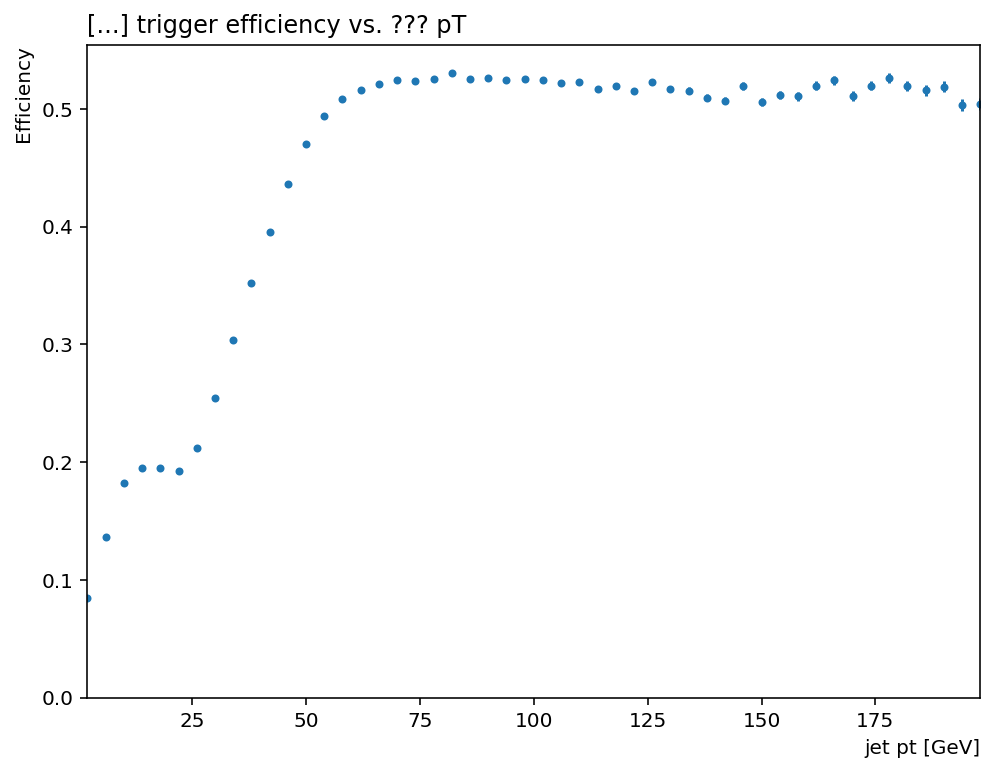

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
numer = output['tot_tag_with_probe'].project('dataset')
denom = output['tot_tag'].project('dataset')

fig, ax, _ = hist.plotratio(num=numer,
                            denom=denom,
                            error_opts={'marker': '.'},
                            unc='clopper-pearson',
                            ax=ax)
#ax.text(60, 0.1, '\n'.join(['logical OR of:',]+ Triggers))
ax.set_title('[...] trigger efficiency vs. ??? pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");


### Old way to plot the efficiency

In [51]:
# common plotting options

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

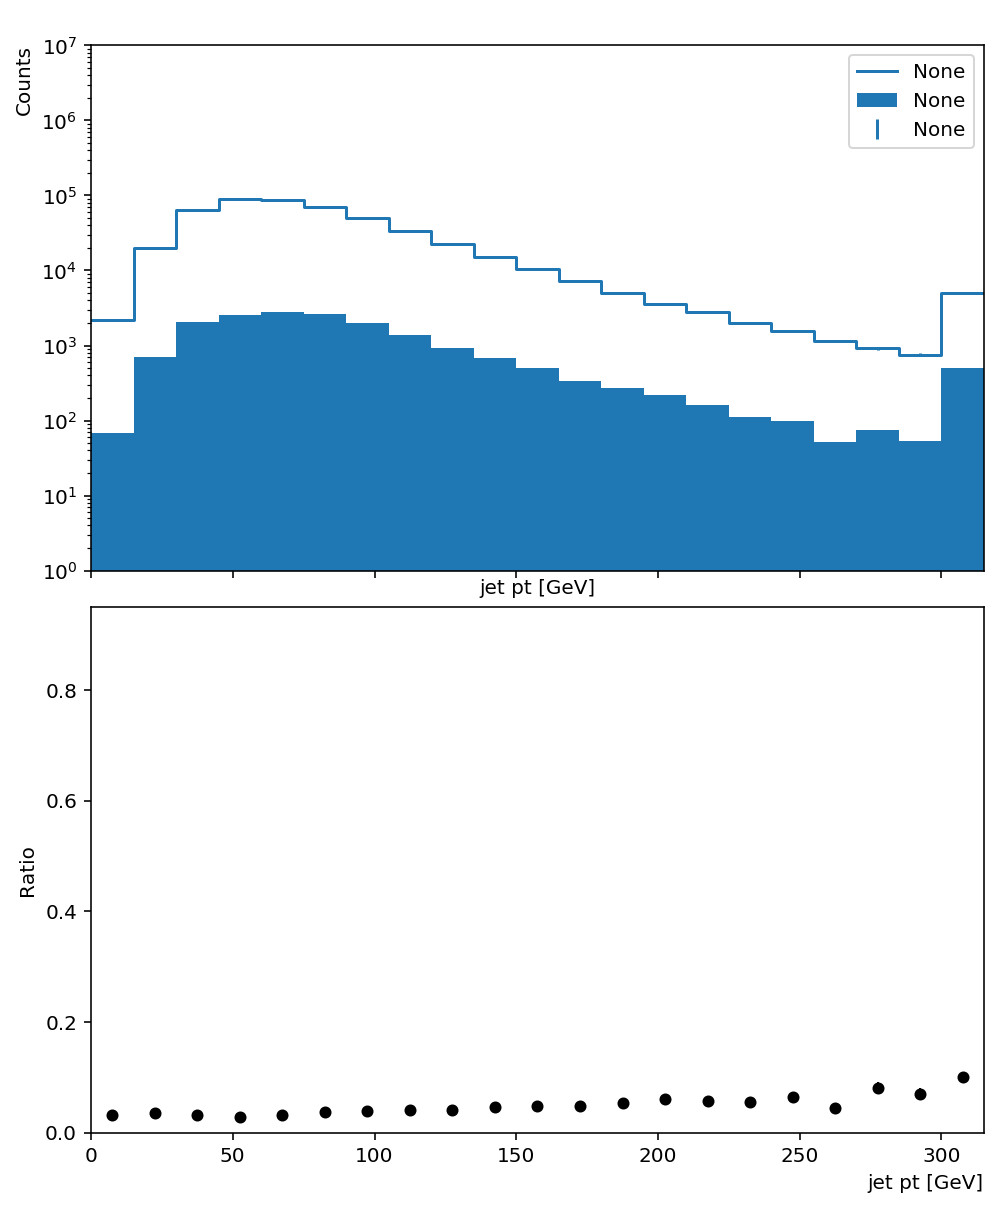

In [52]:
# EFFICIENCY (ratio-plot)

fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,10), gridspec_kw={"height_ratios": (1, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['tot_tag_with_probe'].sum('dataset'),       # sum() is summing all the datasets, I immagine
           #overlay='dataset',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           #fill_opts=fill_opts,
           #error_opts=error_opts
           )
hist.plot1d(output['tot_tag'].sum('dataset'),
           #overlay='dataset',
           ax=ax,
           overflow='over',
           clear=False,
           #error_opts=data_err_opts
           )
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel('jet pt [GeV]')
leg=ax.legend()

hist.plotratio(output['tot_tag_with_probe'].sum('dataset'), output['tot_tag'].sum('dataset'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num'
              )
rax.set_ylabel('Ratio')
rax.set_ylim(0,0.95)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('      ', x=0.0, ha="left");

#ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);




